# Textual similarity

We'll start by importing some things we will need later on.  Seaborn is a package that makes Matplotlib look nicer. 

In [ ]:
#pip install matplotlib seaborn nltk

In [ ]:
#pip install scikit-learn

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
import os
import math
from matplotlib.colors import LogNorm
import nltk
nltk.download('punkt')
nltk.download('punkt_tab')
import operator

[nltk_data] Downloading package punkt to /Users/wilson/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/wilson/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


## Document vectors

We need a way to "vectorize" the text - i.e. convert each sample from a string of characters into some (fixed) number of features. We'll be doing this a lot, so we will go through it carefully.

To start, let's suppose we have a short list of documents:

In [2]:
raw_texts = ["This is the text of the first document", 
             "This is the second one", 
             "Some other document", 
             "The next one", 
             "Another document - the last document in our list of documents"]

An easy way to quickly tokenize a string into a list of words is to use nltk's word_tokenize function.  For now we won't do any lemmatization.

In [3]:
print(raw_texts[0])
print(word_tokenize(raw_texts[4]))

This is the text of the first document
['Another', 'document', '-', 'the', 'last', 'document', 'in', 'our', 'list', 'of', 'documents']


Since we're going to be treating documents as sequences of tokens, we can start by turning each document into a list of tokens:

In [4]:
def text_to_documents(raw):
    docs = []
    for text in raw:
        docs.append([word.lower() for word in word_tokenize(text)])
    return docs

documents = text_to_documents(raw_texts)
documents

[['this', 'is', 'the', 'text', 'of', 'the', 'first', 'document'],
 ['this', 'is', 'the', 'second', 'one'],
 ['some', 'other', 'document'],
 ['the', 'next', 'one'],
 ['another',
  'document',
  '-',
  'the',
  'last',
  'document',
  'in',
  'our',
  'list',
  'of',
  'documents']]

In order to do any vectorization, we're going to need to know what all the unique tokens are. For convenience, we define a function that takes a list of lists (i.e. a list of documents), and returns the unique tokens:

In [5]:
def unique_terms(docs):
    words = {}
    for doc in docs:
        for word in doc:
            words[word] = True
    return list(words.keys())

E.g. the unique terms in just the *first* document:

In [6]:
unique_terms([documents[0]])

['this', 'is', 'the', 'text', 'of', 'first', 'document']

Or, alternatively:

In [ ]:
set(documents[0])

What we're really interested in however is the list of unique terms across *all* documents:

In [7]:
terms = unique_terms(documents)
print(terms)
len(terms)

['this', 'is', 'the', 'text', 'of', 'first', 'document', 'second', 'one', 'some', 'other', 'next', 'another', '-', 'last', 'in', 'our', 'list', 'documents']


19

Alternatively, we can create a list of sets:

In [9]:
sets = [set(doc) for doc in documents]
sets

[{'document', 'first', 'is', 'of', 'text', 'the', 'this'},
 {'is', 'one', 'second', 'the', 'this'},
 {'document', 'other', 'some'},
 {'next', 'one', 'the'},
 {'-',
  'another',
  'document',
  'documents',
  'in',
  'last',
  'list',
  'of',
  'our',
  'the'}]

And then make a set that is the union of all of the sets in the list. This uses more advanced Python syntax (the asterisk is a list expansion):

In [10]:
terms2 = set.union(*sets)
terms2

{'-',
 'another',
 'document',
 'documents',
 'first',
 'in',
 'is',
 'last',
 'list',
 'next',
 'of',
 'one',
 'other',
 'our',
 'second',
 'some',
 'text',
 'the',
 'this'}

Now we have a list of terms, we can use this to vectorize a document. The order of information in our vectors will be determined by the order of our term list:

In [8]:
def document_tf_vector(doc, terms):
    vector = []
    for term in terms:
        vector.append(doc.count(term))
    return vector

Let's try this first for a single document:

In [11]:
print(documents[0])
document_tf_vector(documents[0], terms)

['this', 'is', 'the', 'text', 'of', 'the', 'first', 'document']


[1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

We can use this to turn all of our documents into TF vectors; if we turn this into a Pandas dataframe, we can also add our term list as column headings to better see what's going on:

In [12]:
def document_tf_vectors(docs, terms):
    vectors = []
    for doc in docs:
        vectors.append(document_tf_vector(doc, terms))
    return vectors

In [13]:
vectors = document_tf_vectors(documents, terms)
vectors

[[1, 1, 2, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
 [0, 0, 1, 0, 1, 0, 2, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]]

In [14]:
df = pd.DataFrame(vectors, columns=terms)
df

,this,is,the,text,of,first,document,second,one,some,other,next,another,-,last,in,our,list,documents
0,1,1,2,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0
1,1,1,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,1,0,2,0,0,0,0,0,1,1,1,1,1,1,1


Now we have vectors, we can start comparing them; let's define cosine similarity:

In [15]:
def cosine_similarity(vector1, vector2):
    assert len(vector1) == len(vector2)
    product = 0
    norm1squared = 0
    norm2squared = 0
    for value1, value2 in zip(vector1, vector2):
        product += value1*value2
        norm1squared += value1**2
        norm2squared += value2**2
    return product/(math.sqrt(norm1squared * norm2squared))

In [16]:
# How similar is vector 0 (document 0) to vector 1 (document 1)?
print(cosine_similarity(vectors[0], vectors[1]))

# How similar is vector 3 (document 3) to vector 3 (document 3)?
print(cosine_similarity(vectors[3], vectors[3]))

0.565685424949238
1.0


Although we're still using just term frequency, this is a good point to start looking at how we might make a global comparison among all of our documents.

In [17]:
def compare_all_vectors(vectors):
    matrix = []
    for vector_i in vectors:
        row = []
        for vector_j in vectors:
            row.append(cosine_similarity(vector_i, vector_j))
        matrix.append(row)
    return matrix

In [18]:
matrix = compare_all_vectors(vectors)
matrix

[[1.0,
  0.565685424949238,
  0.18257418583505536,
  0.3651483716701107,
  0.43852900965351466],
 [0.565685424949238, 1.0, 0.0, 0.5163977794943222, 0.12403473458920847],
 [0.18257418583505536, 0.0, 1.0, 0.0, 0.32025630761017426],
 [0.3651483716701107, 0.5163977794943222, 0.0, 1.0, 0.16012815380508713],
 [0.43852900965351466,
  0.12403473458920847,
  0.32025630761017426,
  0.16012815380508713,
  1.0]]

A matrix isn't that easy to read directly, but it corresponds to an intuitive heatmap - let's define a helper function for that too:

In [19]:
def compare_all_heatmap(vectors):
    matrix = compare_all_vectors(vectors)
    plt.figure(figsize=(10,10))
    sns.heatmap(matrix, square=True, annot=True, cmap='Reds', cbar=True)
    plt.xlabel('Document vector #')
    plt.ylabel('Document vector #');
    plt.show()

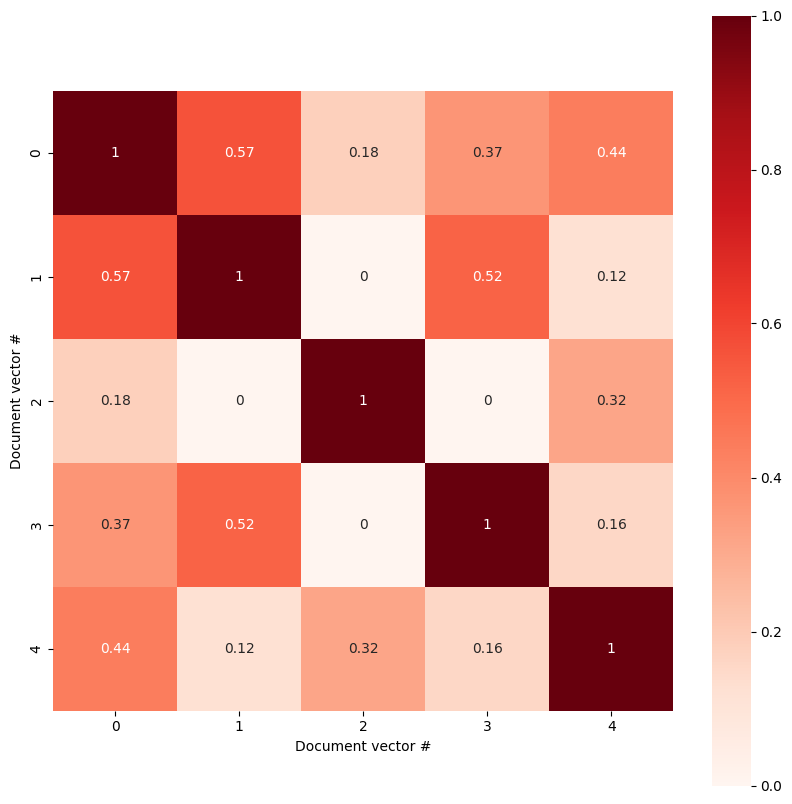

In [20]:
compare_all_heatmap(vectors)

**Q:** Which two documents in this simple example are the most similar according to cosine similarity on TF vectors? With reference to the contents of the documents, *why* do we get this result?

Since we defined each individual step as a function, we can repeat things quite easily with a different corpus - let's use a very simple one with two terms:

In [21]:
raw_texts = ["cat cat cat cat mouse", \
             "cat dog", \
             "dog dog cat dog", \
             "dog dog cat cat", \
             "cat cat cat dog", \
             "dog dog dog dog mouse" ]

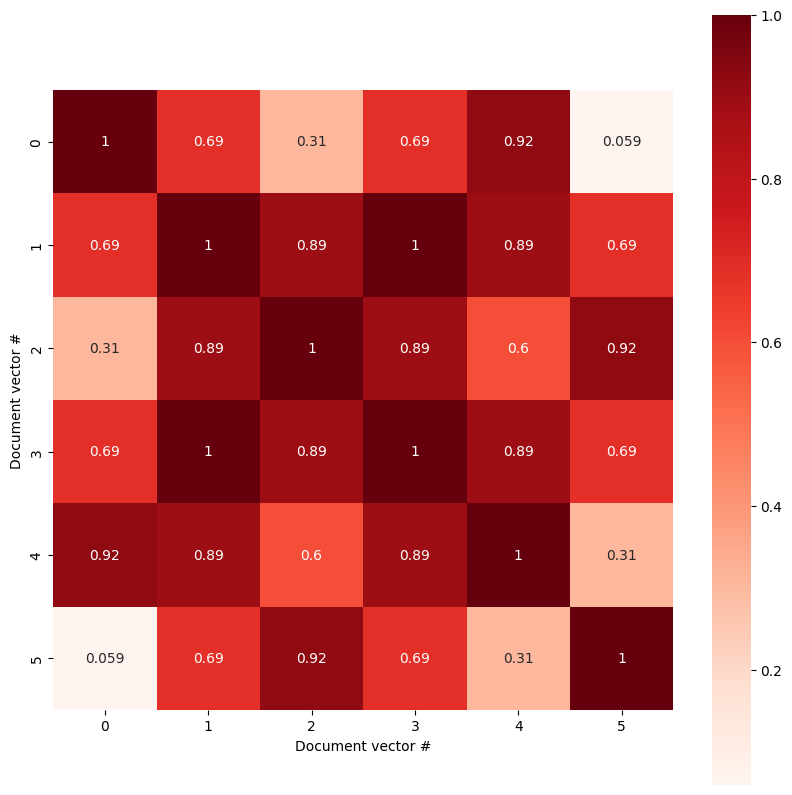

In [22]:
documents = text_to_documents(raw_texts)
terms = unique_terms(documents)
vectors = document_tf_vectors(documents, terms)
compare_all_heatmap(vectors)

**Q:**  Why are there two cells off the diagonal with one in them?

Now we can see similarity comparisons, we can implement Inverse Document Frequency weighting.

In [23]:
def df(term, documents):
    count = 0
    for doc in documents:
        if term in doc:
            count += 1
    return count

In [24]:
def idf(term, documents):
    n = len(documents)
    return math.log(n/df(term, documents))

We can now compute the document frequency and inverse document frequency of any term in our set of documents:

In [25]:
print(df("dog", documents))
print(idf("dog", documents))

print(df("mouse", documents))
print(idf("mouse", documents))

5
0.1823215567939546
2
1.0986122886681098


We can use this to construct document vectors, this time using TF-IDF instead of just TF:

In [26]:
def document_tfidf_vector(doc, terms, documents):
    vector = []
    for term in terms:
        vector.append(doc.count(term) * idf(term, documents))
    return vector

In [27]:
def document_tfidf_vectors(docs, terms):
    vectors = []
    for doc in docs:
        vectors.append(document_tfidf_vector(doc, terms, docs))
    return vectors

Now we have this, we can construct a comparison matrix, and plot it as a heatmap exactly as before:

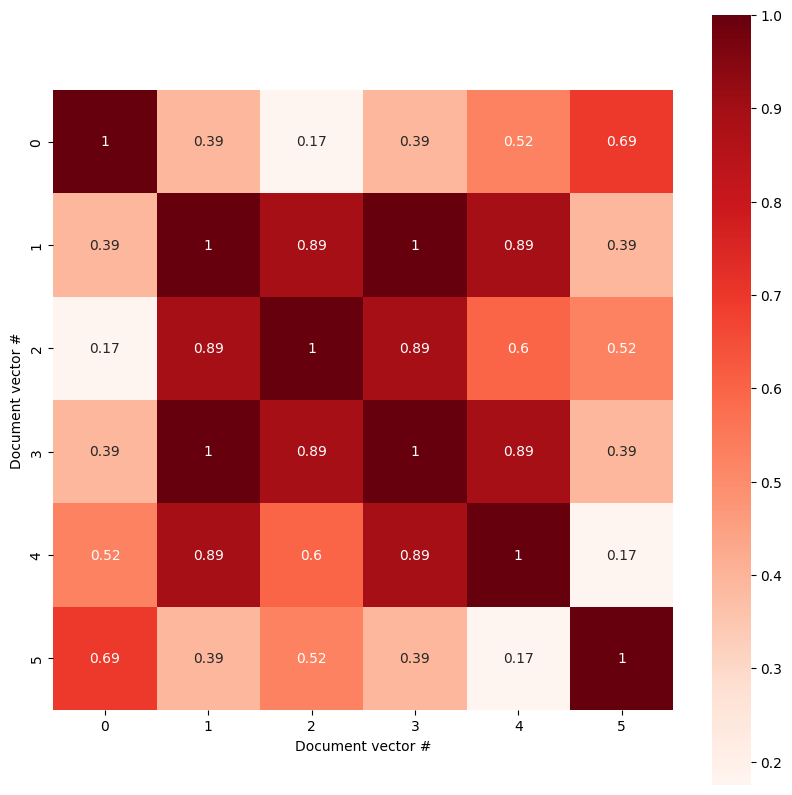

In [28]:
vectors = document_tfidf_vectors(documents, terms)
compare_all_heatmap(vectors)

**Q:** Compare the output for this example (cats+dogs, TF-IDF) with the earlier output (cats+dogs, TF). Are there any differences? Explain why we get this result with this corpus (hint: think about the IDF values for each of the terms in this very small corpus).

**Q:** Our corpus was intentionally constructed with just two unique terms. What happens if you add a third term to one of the documents (e.g. mouse to the last one)?

**Q:** What happens if you additionally add another, different term to another of the documents (e.g. rat to the first one)? Which of the two charts (TF, or TF-IDF) is more radically altered by these changes? Why is this?  

**Q:** What if you add the first new term to the second document instead?

## A real corpus

So far we've just played around with very short documents to better understand what's going on. In this section, we'll load more realistic documents from text files instead.

**Note:** before running this code, you will need to unzip the text files and put the two folders in the same folder as this notebook.

So you should have a folder named `alice1` and another named `alice2`.

We define a helper function to read all the `.txt` files in a specified folder:

In [29]:
def read_directory(folder):
    texts = []
    labels = []
    for filename in os.listdir(folder):
        if filename.endswith(".txt"):
            labels.append(filename)
    labels.sort()
    for filename in labels:
        with open(os.path.join(folder, filename), encoding="utf-8") as f:
            texts.append(f.read())
    return [texts, labels]

Our first example text is a copy of Alice in Wonderland:

In [33]:
raw_texts, labels = read_directory("alice1")
raw_texts[1][:1000]

"'Curiouser and curiouser!' cried Alice (she was so much surprised, that for the moment she quite forgot how to speak good English); 'now I'm opening out like the largest telescope that ever was! Good-bye, feet!' (for when she looked down at her feet, they seemed to be almost out of sight, they were getting so far off). 'Oh, my poor little feet, I wonder who will put on your shoes and stockings for you now, dears? I'm sure I shan't be able! I shall be a great deal too far off to trouble myself about you: you must manage the best way you can;—but I must be kind to them,' thought Alice, 'or perhaps they won't walk the way I want to go! Let me see: I'll give them a new pair of boots every Christmas.'\n\nAnd she went on planning to herself how she would manage it. 'They must go by the carrier,' she thought; 'and how funny it'll seem, sending presents to one's own feet! And how odd the directions will look!\n\n Alice's Right Foot, Esq.\n Hearthrug,\n near The Fender,\n (with Alice's love).\

Our function also gives us the filenames so we can keep track of which file is which document:

In [34]:
labels

['ch01.txt',
 'ch02.txt',
 'ch03.txt',
 'ch04.txt',
 'ch05.txt',
 'ch06.txt',
 'ch07.txt',
 'ch08.txt',
 'ch09.txt',
 'ch10.txt',
 'ch11.txt',
 'ch12.txt']

We defined all the steps above as functions, so we can re-run the same steps on our new corpus easily:

In [35]:
documents = text_to_documents(raw_texts)
terms = unique_terms(documents)
vectors = document_tfidf_vectors(documents, terms)

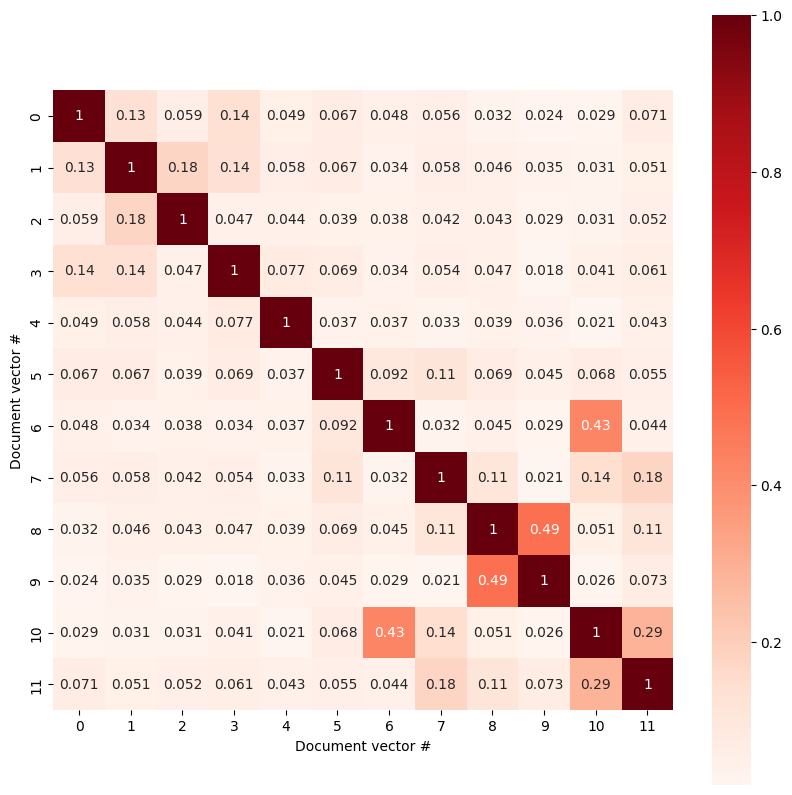

In [36]:
compare_all_heatmap(vectors)

Next, we'll load  a separate text - the manuscript version "Alice's adventures underground" ("alice2" folder), which differs substantially from the published 12 chapter version of the text ("alice1" folder):

In [37]:
raw_texts2, labels2 = read_directory("alice2")
documents = text_to_documents(raw_texts + raw_texts2)

In [38]:
labels2

['ch_01.txt', 'ch_02.txt', 'ch_03.txt', 'ch_04.txt']

In [39]:
terms = unique_terms(documents)
vectors = document_tfidf_vectors(documents, terms)

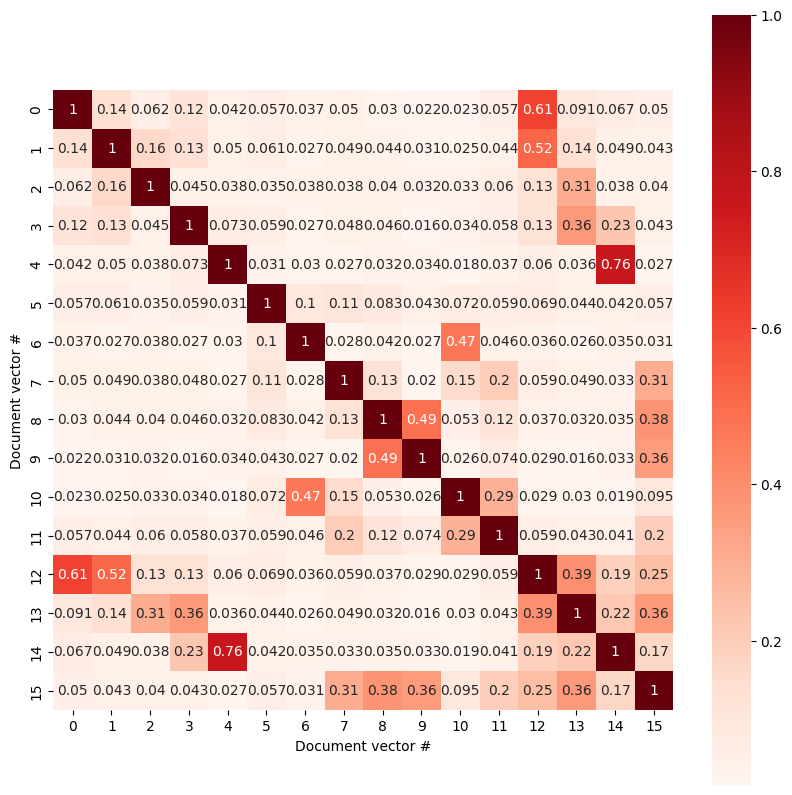

In [40]:
compare_all_heatmap(vectors)

We can see some interesting similarities between the two versions of Alice in Wonderland.

* Using the heatmap, which chapters of the 12-chapter edition (files in the "alice1" folder) likely correspond to the first chapter of the 4-chapter edition?

## N-grams

We will use the `ngrams` function from NLTK to extract n-grams from our texts.

In [41]:
raw_texts = ["This is the text of the first document", \
             "This is the second one", \
             "Some other document", \
             "The next one", \
             "Another document - the last document in our list of documents"]
documents = text_to_documents(raw_texts)

For convenience, we'll define a variable "N" and use that as the "n" in "n-gram":

In [42]:
N = 2

In [43]:
ng = list(ngrams(documents[0], N))
ng

[('this', 'is'),
 ('is', 'the'),
 ('the', 'text'),
 ('text', 'of'),
 ('of', 'the'),
 ('the', 'first'),
 ('first', 'document')]

An easy way to define the Jaccard index will be to make use of Python's set functions. Unlike a list, a set does not allow duplicated members:

In [44]:
a = set([1,2,2,2,2,3,4])
a

{1, 2, 3, 4}

In [45]:
b = set([2,3,4,5,5,5,5])
b

{2, 3, 4, 5}

This is a convenient way to define Jaccard index, because Python has operators for intersection (&) and union (|) of sets:

In [46]:
a&b

{2, 3, 4}

In [47]:
a|b

{1, 2, 3, 4, 5}

By using these operators, our definition becomes very simple:

In [48]:
def jaccard_index(a, b):
    a = set(a)
    b = set(b)
    if len(a|b) == 0:
        return 0
    else:
        return 1.0 * len(a&b)/len(a|b)

We can use this to compare the similarity of lists of ngrams, e.g.:

In [49]:
ng1 = list(ngrams(documents[0], N))
ng2 = list(ngrams(documents[1], N))
jaccard_index(ng1, ng2)

0.2222222222222222

For convenience, we can also define a function that builds a list of ngrams for each of our documents:

In [50]:
def build_ngrams(documents, N):
    ngram_list = []
    for doc in documents:
        ngram_list.append(list(ngrams(doc, N)))
    return ngram_list

In [51]:
ngram_list = build_ngrams(documents, N)
ngram_list

[[('this', 'is'),
  ('is', 'the'),
  ('the', 'text'),
  ('text', 'of'),
  ('of', 'the'),
  ('the', 'first'),
  ('first', 'document')],
 [('this', 'is'), ('is', 'the'), ('the', 'second'), ('second', 'one')],
 [('some', 'other'), ('other', 'document')],
 [('the', 'next'), ('next', 'one')],
 [('another', 'document'),
  ('document', '-'),
  ('-', 'the'),
  ('the', 'last'),
  ('last', 'document'),
  ('document', 'in'),
  ('in', 'our'),
  ('our', 'list'),
  ('list', 'of'),
  ('of', 'documents')]]

Just as with cosine similarity, a matrix containing all comparisons will help give us a good overview of all possible results:

In [52]:
def compare_all_ngrams(ngram_list):
    matrix = []
    for ngram_i in ngram_list:
        row = []
        for ngram_j in ngram_list:
            row.append(jaccard_index(ngram_i, ngram_j))
        matrix.append(row)
    return matrix

In [53]:
compare_all_ngrams(ngram_list)

[[1.0, 0.2222222222222222, 0.0, 0.0, 0.0],
 [0.2222222222222222, 1.0, 0.0, 0.0, 0.0],
 [0.0, 0.0, 1.0, 0.0, 0.0],
 [0.0, 0.0, 0.0, 1.0, 0.0],
 [0.0, 0.0, 0.0, 0.0, 1.0]]

And again, this matrix is going to be much easier to look at as a heatmap:

In [54]:
def compare_all_ngrams_heatmap(ngram_list):
    matrix = compare_all_ngrams(ngram_list)
    plt.figure(figsize=(10,10))
    sns.heatmap(matrix, square=True, annot=True, cmap='Reds', cbar=True, norm=LogNorm())
    plt.xlabel('Document vector')
    plt.ylabel('Document vector');
    plt.show()


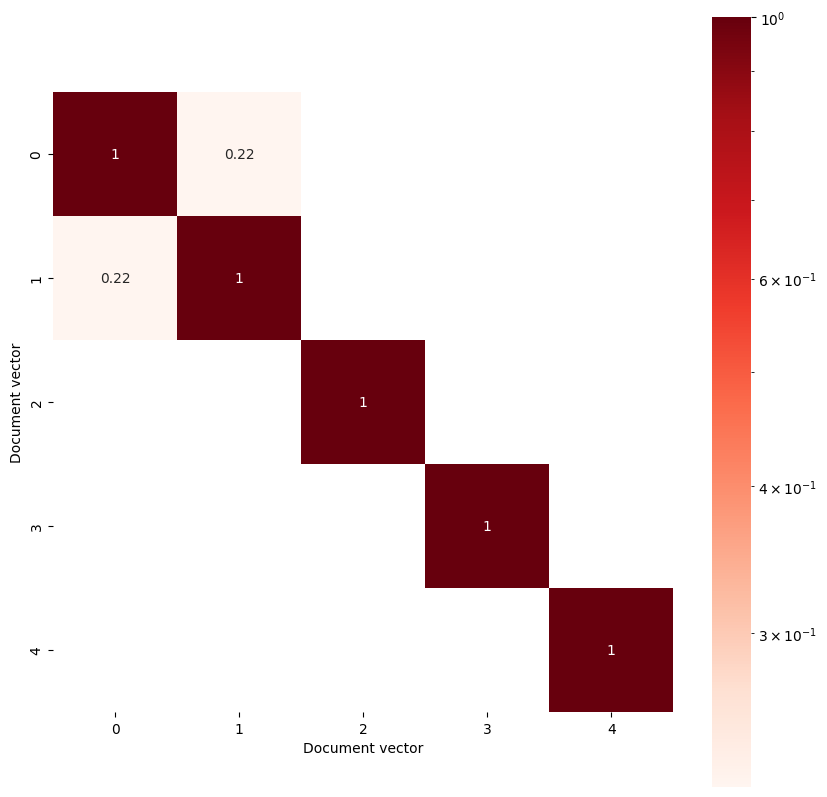

In [55]:
compare_all_ngrams_heatmap(ngram_list)

We can use the set operators to examine which specific ngrams are shared between any two documents:

In [57]:
set(ngram_list[0]) & set(ngram_list[1])

{('is', 'the'), ('this', 'is')}

Although there are shared n-grams, there isn't a huge amount of obvious reuse in our current corpus.  Let's try the two versions of Alice. 

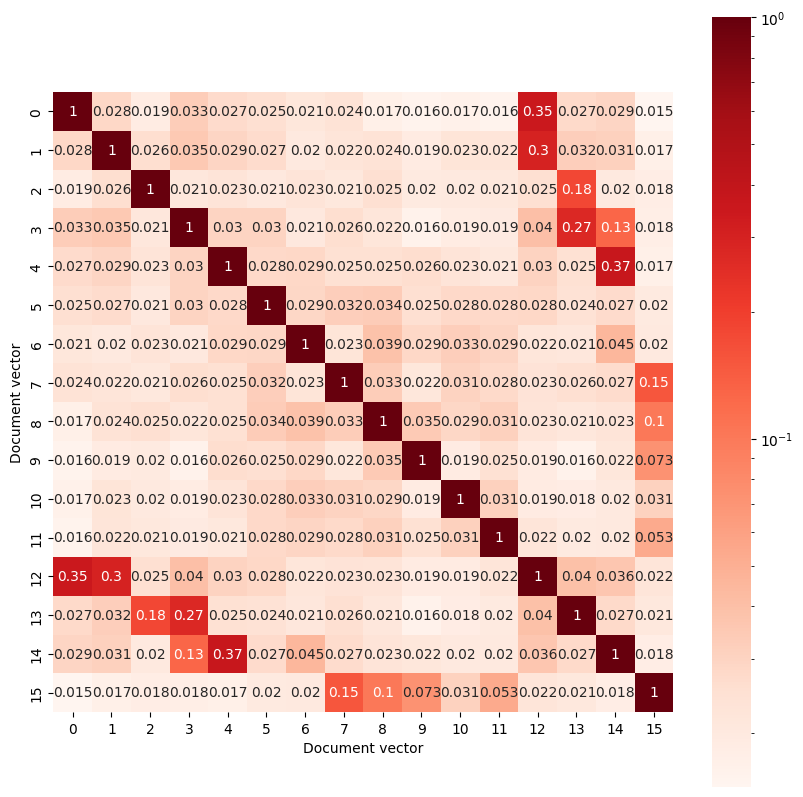

In [68]:
N = 3
raw_texts, labels = read_directory("alice1")
raw_texts2, labels2 = read_directory("alice2")
documents = text_to_documents(raw_texts + raw_texts2)
ngram_list = build_ngrams(documents, N)
compare_all_ngrams_heatmap(ngram_list)

In [69]:
print(len(ngram_list), len(ngram_list[0]))
ngram_list[0][:10]

16 2533


[('alice', 'was', 'beginning'),
 ('was', 'beginning', 'to'),
 ('beginning', 'to', 'get'),
 ('to', 'get', 'very'),
 ('get', 'very', 'tired'),
 ('very', 'tired', 'of'),
 ('tired', 'of', 'sitting'),
 ('of', 'sitting', 'by'),
 ('sitting', 'by', 'her'),
 ('by', 'her', 'sister')]

**Q:** How dependent are the general trends visible in the heatmap on the chosen value of N? Experiment with different values.

## Sklearn implementation

Our implementation of TF-IDF and cosine similarity is very slow with large documents, because it's intentionally written to favour readability over performance. 

In the future, we will use the **much** more efficient implementation that is included in the sklearn library as "[TfidfVectorizer](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html)". You can experiment with this library, and compare the results with those from the code above.

As we will see, there are minor differences between the sklearn implementation and the standard version of TF-IDF described in class and implemented in this notebook. See the sklearn documentation for the differences.

### TfidfVectorizer

In [70]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [59]:
vectorizer = TfidfVectorizer(norm=None,sublinear_tf=True)

In [60]:
tfidf = vectorizer.fit_transform(raw_texts + raw_texts2)

In [71]:
tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 3535 stored elements and shape (9, 2092)>

In [72]:
tfidf.toarray()

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.60943791, 0.        ,
        2.60943791],
       [2.60943791, 2.60943791, 2.60943791, ..., 0.        , 0.        ,
        0.        ]])

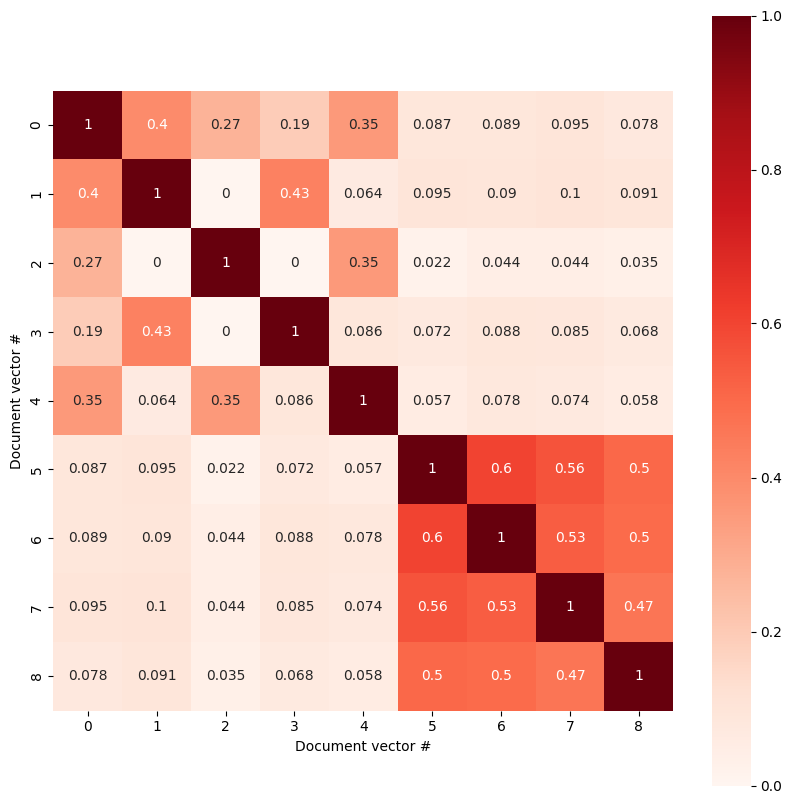

In [73]:
compare_all_heatmap(tfidf.toarray())

### CountVectorizer (for ngrams)

In [74]:
vectorizer = CountVectorizer(ngram_range=(2,2), lowercase=True)
counts = vectorizer.fit_transform(raw_texts + raw_texts2)

In [75]:
print(len(vectorizer.get_feature_names_out()))
vectorizer.get_feature_names_out()[0:30]

17068


array(['1886 an', '30 in', '_and are', '_and be', '_and if', '_and many',
       '_and my', '_and themselves', '_and would', '_are these',
       '_attitude to', '_be happy', '_dec 1886', '_do you', '_for do',
       '_goody and', '_groping blindly', '_hands on', '_i want',
       '_i would', '_is_ it', '_knowing that_', '_knows_ you', '_let me',
       '_lewis carroll', '_lewis carroll_', '_loves them', '_p the',
       '_please to', '_postscript _the'], dtype=object)

In [76]:
counts

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 31402 stored elements and shape (16, 17068)>

We have counts of ngrams rather than lists of ngrams, so we use the original heatmap function, which uses cosine similarity.

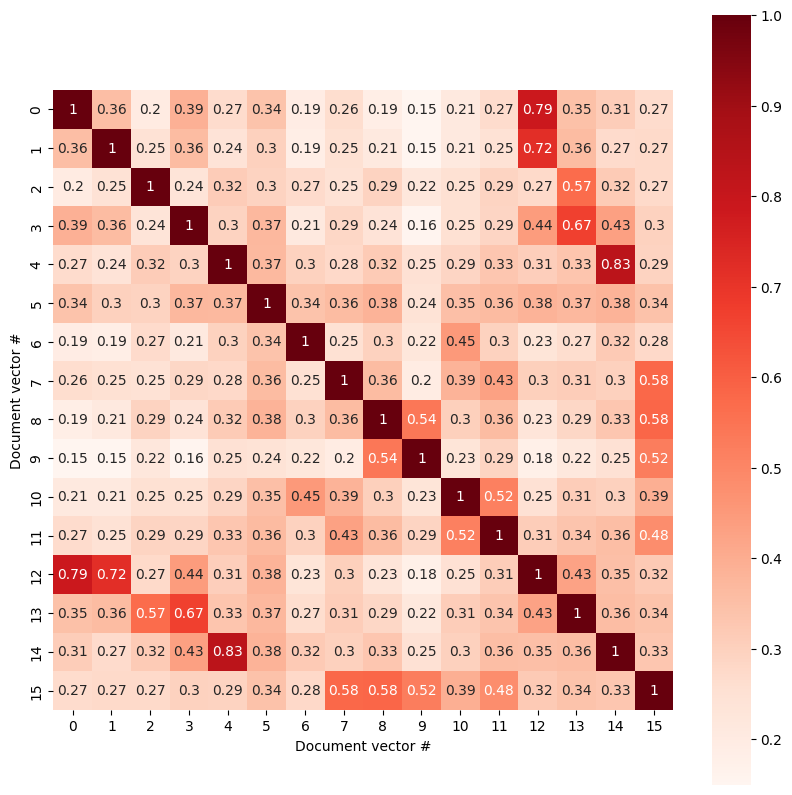

In [77]:
compare_all_heatmap(counts.toarray())